In [1]:
# 基于单一种群的特征选择方法
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pyes
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.python.framework.errors_impl import InvalidArgumentError
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance
from loguru import logger
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
data = np.genfromtxt('../exampleData/glass.data', delimiter=',')

In [3]:
# 数据概览
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1.0
1,2.0,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1.0
2,3.0,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1.0
3,4.0,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1.0
4,5.0,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
209,210.0,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7.0
210,211.0,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7.0
211,212.0,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7.0
212,213.0,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7.0


In [4]:
n_row, n_col = data.shape
print('number of rows: {n_row}, number of column: {n_col}'.format(n_row=n_row, n_col=n_col))

number of rows: 214, number of column: 11


In [50]:
def encode(solution):
    """用于将个体编码成二进制形式，用于选择特征"""
    v_func = lambda x: 1.0 / (1.0 + np.exp(-x*2))
    return [True if v_func(x) > 0.5 else False for x in solution]

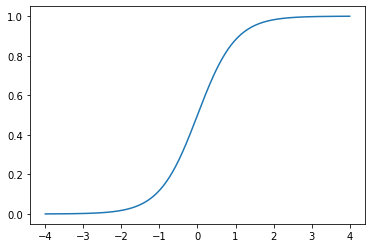

In [51]:
# 非关键代码，用于验证 v_func 函数图像是否与文章中"图 4.1" 一致
v_func = lambda x: 1.0 / (1.0 + np.exp(-x*2))
x = np.linspace(-4, 4, 300)
plt.plot(x, [v_func(v) for v in x])

In [7]:
def DR(encoded_x):
    """计算特征维度缩减率"""
    return 1 - 1.0 * sum([1 for v in encoded_x if v]) / len(encoded_x)

In [8]:
# 非关键代码，用于测试 DR 函数
test_encoded_xs = np.ones((10, 10), dtype=bool)
mask = np.random.normal(0, 1, (10, 10)) > 0
test_encoded_xs[mask] = False
df = pd.DataFrame(test_encoded_xs)
df[10] = [DR(x) for x in test_encoded_xs]
df

,0,1,2,3,4,5,6,7,8,9,10
0,True,True,True,False,False,True,True,True,False,True,0.3
1,True,False,False,False,True,True,True,False,True,True,0.4
2,True,False,True,True,True,True,False,False,True,False,0.4
3,False,False,False,False,False,False,True,True,False,False,0.8
4,False,False,True,False,False,True,False,False,False,True,0.7
5,True,True,False,False,True,False,True,True,True,False,0.4
6,False,False,True,True,False,True,True,False,True,True,0.4
7,False,True,True,False,True,True,True,False,False,True,0.4
8,False,True,True,False,True,False,True,False,False,False,0.6
9,False,True,True,True,True,False,False,False,True,True,0.4


In [9]:
def CA(encode_x, data_X, data_y):
    """计算分类准确率"""
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(data_X[:,encode_x], data_y)
    return clf.score(data_X[:,encode_x], data_y)

In [10]:
# 非关键代码，用于测试 CA 函数
encode_x = np.ones(n_col-1, dtype=bool)
encode_x[np.random.normal(0, 1, n_col-1) > 0] = False

ca = CA(encode_x, data[:,:10], data[:,10])
print('准确率为: {ca}, 选中的特征下标: {idxs_feature}'.format(ca=ca, idxs_feature='-'.join([str(i) for i, v in enumerate(encode_x) if v])))

准确率为: 0.9345794392523364, 选中的特征下标: 0-1-3-6-7-8-9


In [39]:
# 目标函数包含 CA 和 DR 两部分内容，如果需要修改分类器，请修改 CA 函数
# 说明：文章中"图 4.2" 曲线与给定的公式 4.2 是对不上的，所以按最曲线重新定义了个 rho 函数
def rho(l):
    return 0.90 + 0.099 / (l/2000 + 1)

def objective(encode_x, data_X, data_y):
    l = len(encode_x)
    return rho(l) * CA(encode_x, data_X, data_y) + (1 - rho(l)) * DR(encode_x)

Text(0, 0.5, 'Value of Rho')

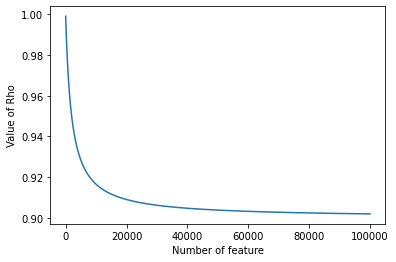

In [12]:
# rho 函数的图示
x = np.linspace(0, 100000, 10000)
plt.plot(x, rho(x))
plt.xlabel('Number of feature')
plt.ylabel('Value of Rho')

In [13]:
# 非关键代码，目标函数的测试 1
p = np.random.normal(0, 1, (20, 10)) # 测试种群
encoded_p = [encode(x) for x in p]
pd.DataFrame(encoded_p).head(5) # 编码后种群(前 5 个)

,0,1,2,3,4,5,6,7,8,9
0,False,True,True,True,False,False,True,False,True,True
1,False,True,False,True,True,True,False,False,False,False
2,False,True,True,False,False,False,True,True,True,False
3,False,True,True,False,False,True,True,True,True,True
4,True,True,False,True,True,False,False,True,True,True


In [14]:
# 非关键代码，目标函数的测试 2
df = pd.DataFrame(encoded_p)
df['fitness'] = [objective(encoded_x, data[:,:10], data[:,10]) for encoded_x in encoded_p]
df.head(5)

,0,1,2,3,4,5,6,7,8,9,fitness
0,False,True,True,True,False,False,True,False,True,True,0.742479
1,False,True,False,True,True,True,False,False,False,False,0.710116
2,False,True,True,False,False,False,True,True,True,False,0.695969
3,False,True,True,False,False,True,True,True,True,True,0.746995
4,True,True,False,True,True,False,False,True,True,True,0.924300


In [15]:
def real_objectives(lam, population, data_X, data_y):
    """
    适应值塑造,对应文章中的公式 4.3, 返回 lam 个塑造后的较优适应值，及各个体下标
    """
    encoded_population = [encode(x) for x in population]
    fitness_values = [objective(x, data_X, data_y) for x in encoded_population]
    # 取前 lam 个适应值较优的个体下标,再按升序排列
    selected = np.argsort(fitness_values)[::-1][:lam][::-1]

    temp = 1.0 * (fitness_values[selected[lam-1]] - fitness_values[selected[0]]) / (lam - 1) 
    
    real_fitness_values = [0] * lam

    for i, idx in enumerate(selected):
        if i == 0:
            real_fitness_values[i] = - (fitness_values[selected[lam-1]] - fitness_values[selected[i]]) / 2
        else:
            real_fitness_values[i] = real_fitness_values[0] + i * temp
    
    return real_fitness_values, selected

In [16]:
# 非关键代码，用于测试 real_objective
real_objectives(lam=12, population=np.random.normal(0, 1, (12, 10)), data_X=data[:,:10], data_y=data[:,10])

([-0.21914911424187478,
  -0.1793038207433521,
  -0.1394585272448294,
  -0.09961323374630672,
  -0.059767940247784035,
  -0.019922646749261363,
  0.019922646749261336,
  0.059767940247784035,
  0.0996132337463067,
  0.13945852724482938,
  0.17930382074335205,
  0.21914911424187478],
 array([10,  3,  6,  2,  0,  9,  8,  4, 11,  5,  7,  1], dtype=int64))

In [26]:
def event_on_generation(gen, population, current_best, history_best):
    best = history_best
    if gen == 0:
        best = current_best
    print('iter: {gen}, best solution(bool): {best}, best idxs: {idxs}'.format(gen=gen, best=encode(best), idxs='-'.join([str(i) for i, v in enumerate(encode(best)) if v])))

In [27]:
def NES(
    n_dimension: int, 
    objective, 
    n_iter, 
    learn_rate, 
    lam,
    mean,
    cov,
    random_state=None, 
    event_on_genration=event_on_generation):

    logger.debug({
        'dimension': n_dimension,
        'n_iter': n_iter,
        'learn_rate': learn_rate,
    })

    tf.set_random_seed(random_state)
    best, best_fitness = None, 1e+10
    
    def get_fitness(population): 
        return [-objective(solution) for solution in population]

    mean = tf.Variable(mean, dtype=tf.float32)
    cov = tf.Variable(cov, dtype=tf.float32)
    mvn = MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)
    make_population = mvn.sample(lam)

    fitness_input = tf.placeholder(tf.float32, [lam, ])
    prob_output = tf.placeholder(tf.float32, [lam, n_dimension])
    loss = -tf.reduce_mean(mvn.log_prob(prob_output) * fitness_input)
    train_op = tf.train.GradientDescentOptimizer(learn_rate).minimize(loss)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    for g in range(n_iter):
        population = sess.run(make_population)

        scores = [objective(c) for c in population]
        
        event_on_genration(g, population, population[np.argsort(scores)[0]], best)

        fitness_values = get_fitness(population)
        sess.run(train_op, {fitness_input: fitness_values, prob_output: population}) 

        for i, score in enumerate([objective(x) for x in population]):
            if score < best_fitness:
                best, best_fitness = population[i], score

    return [best, best_fitness]

In [53]:
n_dimension = n_col - 1
n_iter = 10
learn_rate = 0.002
mu = 4
lam = 12
mean = data[:,:n_dimension].mean(axis=0)
cov = 10000 * tf.eye(n_dimension)
random_state = 1 # 固定输出

def es_objective(x):
    return -objective(encode(x), data[:,:n_dimension], data[:,n_dimension])

In [55]:
best, best_fitness = NES(n_dimension, es_objective, n_iter, learn_rate, lam, mean, cov, random_state, event_on_generation)

2021-07-11 16:14:51.616 | DEBUG    | __main__:NES:15 - {'dimension': 10, 'n_iter': 10, 'learn_rate': 0.002}
iter: 0, best solution(bool): [True, True, False, True, True, True, False, False, False, True], best idxs: 0-1-3-4-5-9
iter: 1, best solution(bool): [True, True, False, True, True, True, False, False, False, True], best idxs: 0-1-3-4-5-9
iter: 2, best solution(bool): [True, True, False, True, True, True, False, False, False, True], best idxs: 0-1-3-4-5-9
iter: 3, best solution(bool): [True, True, False, True, True, True, False, False, False, True], best idxs: 0-1-3-4-5-9
iter: 4, best solution(bool): [True, True, False, True, True, True, False, False, False, True], best idxs: 0-1-3-4-5-9
iter: 5, best solution(bool): [True, True, False, True, True, True, False, False, False, True], best idxs: 0-1-3-4-5-9
iter: 6, best solution(bool): [True, True, True, True, False, True, True, True, True, False], best idxs: 0-1-2-3-5-6-7-8
iter: 7, best solution(bool): [True, True, False, False, 

In [61]:
print('best solution(bool): {best}, best idxs: {idxs}'.format(best=encode(best), idxs='-'.join([str(i) for i, v in enumerate(encode(best)) if v])))
print('维度缩减率 DR: {dr}'.format(dr=DR(encode(best))))
print('分类准确率 CA: {ca}'.format(ca=CA(encode(best), data[:,:n_dimension], data[:,n_dimension])))

best solution(bool): [True, True, False, False, False, True, True, True, False, False], best idxs: 0-1-5-6-7
维度缩减率 DR: 0.5
分类准确率 CA: 0.9532710280373832


In [ ]:
# 结论
# 原先 10 个特征，经过基于 NES 的特征选择方法，特征数缩减至 5 个，同时准确率保持在 95% 以上